In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./output/output.csv')
event = pd.read_csv('./output/event.csv')

In [3]:
df.head()

,ds,y
0,2000-06-01,1.824549
1,2000-06-02,1.816452
2,2000-06-05,1.811562
3,2000-06-06,1.814825
4,2000-06-07,1.813195


In [4]:
#Making a Prediction
#　Create the First Model
from fbprophet import Prophet
model = Prophet(weekly_seasonality=True)
model.fit(df)

In [5]:
#1years = 200days 
future_df = model.make_future_dataframe(200*3)

In [6]:
#add columns yhat_lower,yhat_upper
forecast_df = model.predict(future_df)
forecast_df[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5097,2019-04-20,0.581139,0.326393,0.901021
5098,2019-04-21,0.581591,0.310458,0.859893
5099,2019-04-22,0.573355,0.298805,0.882797
5100,2019-04-23,0.573645,0.309954,0.867893
5101,2019-04-24,0.574353,0.311886,0.891026


In [8]:
np.exp(forecast_df[['yhat','yhat_lower','yhat_upper']])

,yhat,yhat_lower,yhat_upper
0,6.052482,5.321316,6.940584
1,6.050649,5.289504,6.882984
2,6.051191,5.302337,6.963601
3,6.051453,5.298568,6.933103
4,6.054598,5.232601,6.858786
5,6.057623,5.254774,6.979095
6,6.057103,5.281267,6.947840
7,6.059948,5.304098,6.948100
8,6.060342,5.339380,6.924177
9,6.063277,5.263508,6.942140


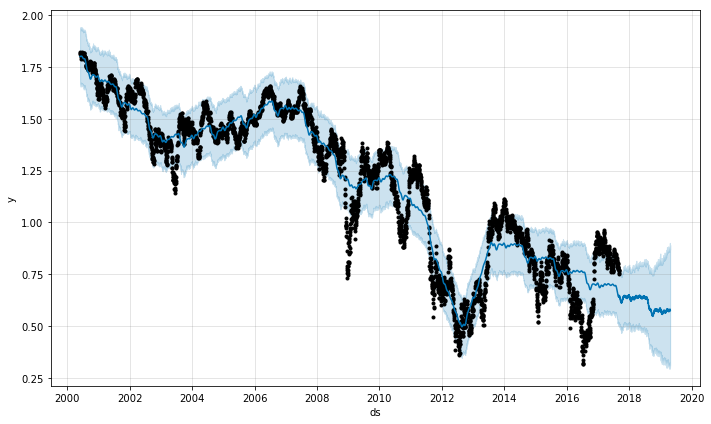

In [9]:
model.plot(forecast_df)

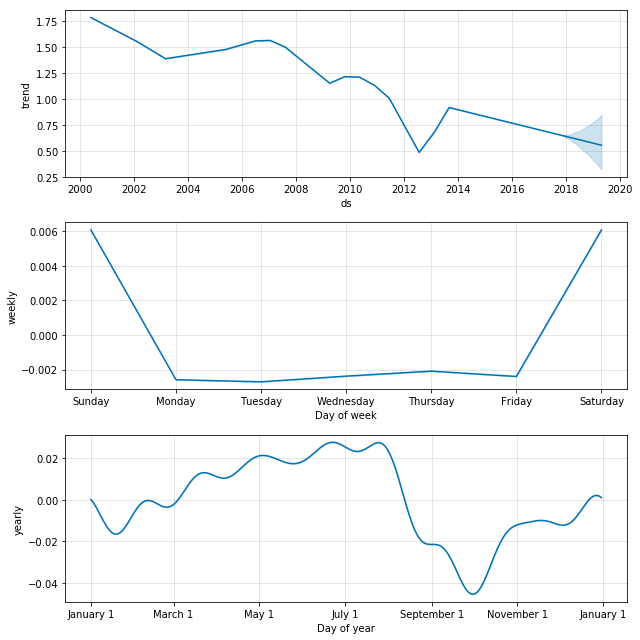

In [10]:
model.plot_components(forecast_df)

In [11]:
model2 = Prophet(holidays=event).fit(df)

In [12]:
forecast_df2 = model2.make_future_dataframe(periods=200*3)
forecast_df2 = model2.predict(forecast_df2)

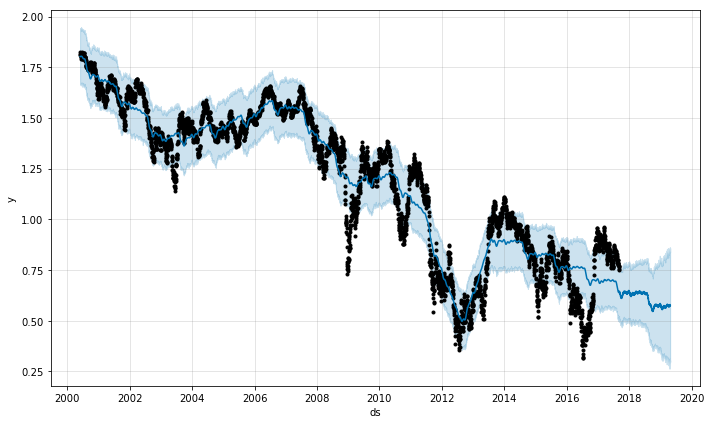

In [13]:
model2.plot(forecast_df2)

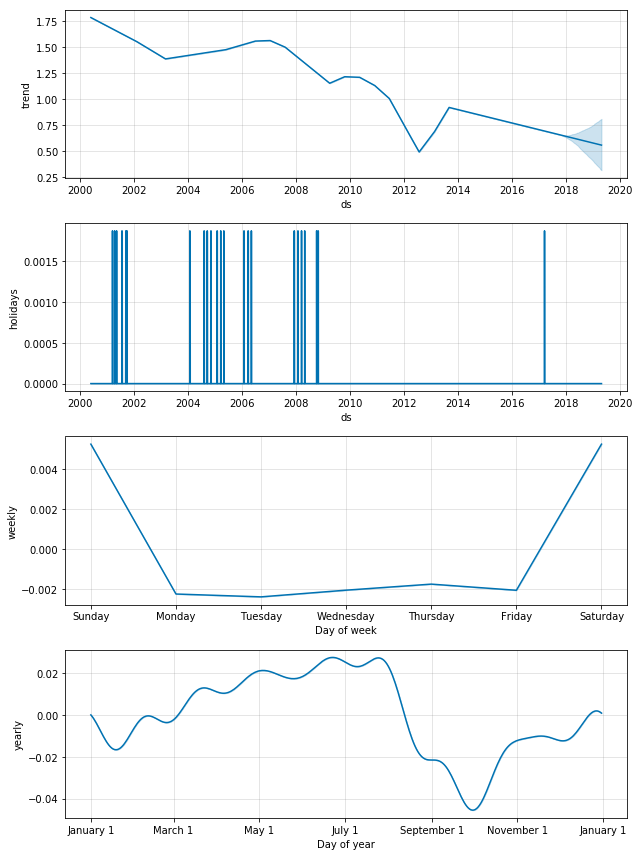

In [14]:
model2.plot_components(forecast_df2)